In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from yellowbrick.text import FreqDistVisualizer

## Input stackOverFlow data

In [2]:
df=pd.read_csv('./stackOverFlowData-5-labels.csv',sep=';')
df = df[pd.notnull(df['label'])]
print(df.head(40000))

                                                    text          label
0      How can I configure DNS for my local Cloud Ser...          cloud
1                  No permission to open MySQL audit log  data-analysis
2                  Dictionary data structure in React JS       frontend
3         applying CSS for particular td tag in a column       frontend
4                  styling bootstrap-vue dropdown button       frontend
...                                                  ...            ...
39995  calculating employee bonus through nested if s...        backend
39996            Looking to get data from multiple sites        backend
39997  Python 3.8+ Does Not Recognize File In Same Fo...        backend
39998                         How to link lists in order        backend
39999  Python subproccess.Popen() error: Fatal error ...        backend

[40000 rows x 2 columns]


## Explore the data

In [3]:
data_words_sum = df['text'].apply(lambda x: len(x.split(' '))).sum()
print("We have " + str(data_words_sum) + " words in the data")

We have 446304 words in the data


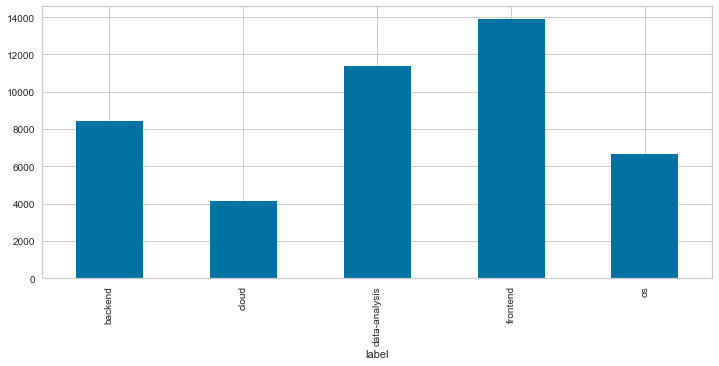

In [4]:
fig = plt.figure(figsize=(12,5))
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show();

## Check the Data
After loading the data, it’s good practice to run some checks on it: pick a few samples and manually check if they are consistent with our expectations. For example, print a few random samples to see if the label corresponds to the content of the post.

In [5]:
def print_plot(index):
    example = df[df.index == index][['text', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label:', example[1])
print_plot(300)
print_plot(30005)
print_plot(3002)

Two views named RNCPicker / Yarn: how to share dependency between dependencies?
Label: frontend
MYSQL get data group by date [duplicate]
Label: data-analysis
Have to render a react component based on props that changes a js variable
Label: frontend


## Visualize Token (vocabulary) Frequency Distribution Before Text Preprocessing
A frequency distribution tells us the frequency of each vocabulary item in the text.

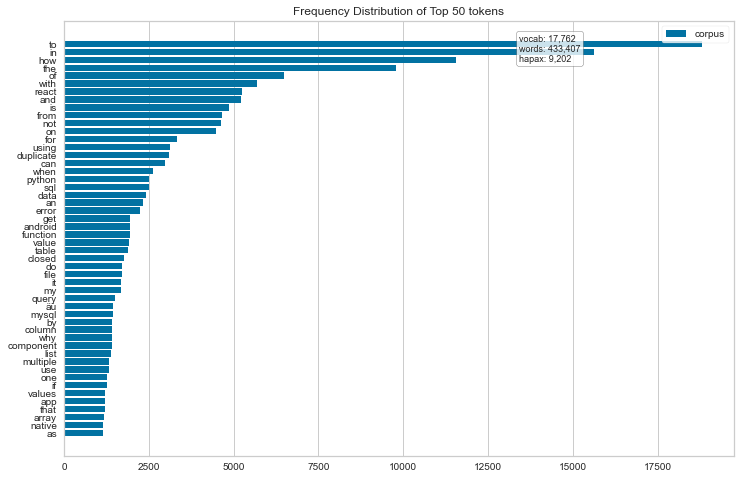

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [6]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df['text'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

## Clean up the data¶
For this particular data set, our text cleaning includes the following steps:

HTML decoding. The BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata. Remove stop words, Change text to lower case Remove punctuation Remove bad characters and so on.

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [8]:
df['text'] = df['text'].apply(clean_text)
print_plot(300)
print_plot(30005)

two views named rncpicker yarn share dependency dependencies
Label: frontend
mysql get data group date duplicate
Label: data-analysis


In [9]:
data_words_sum = df['text'].apply(lambda x: len(x.split(' '))).sum()
print("After cleaning up the data, we have " + str(data_words_sum) + " words in the data")

After cleaning up the data, we have 287474 words in the data


## Visualize Token Frequency Distribution After Text Preprocessing

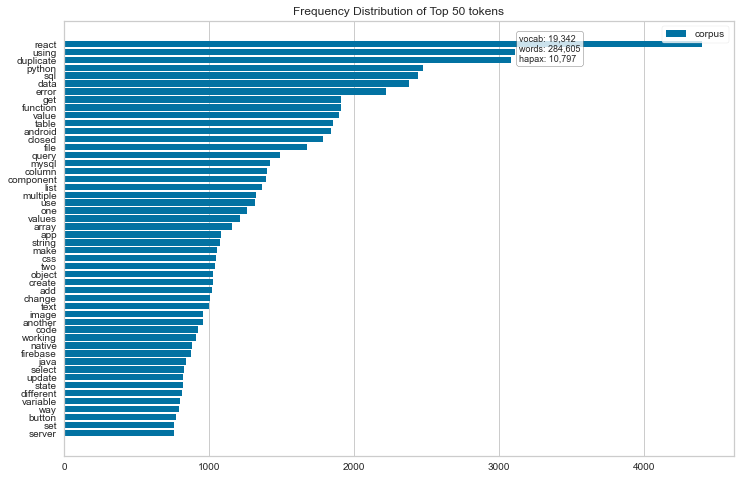

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [10]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df['text'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

## Training data
We will conver our text to a matrix of token counts, then tansform a count matrix to a normalized tf-idf representation (tf-idf transform)

A core step for a typical NLP component is to convert raw text into features, which give a machine learning model a simpler, more focused view of the text.

* We use the LabelEncoder from scikit-learn to convert text labels to integers, 0, 1, 2, 3, ... 19.

* stratify=y will make sure that after random split, the classes are still balanced, in our case.

In [11]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df.label.values)
X_train, X_test, y_train, y_test = train_test_split(df.text.values, y,
                                                   stratify=y, 
                                                   random_state=42, test_size=0.1)

## Tf-idf
term frequency-inverse document

## TfidfVectorizer()
Convert a collection of raw text or document to a matrix of Tf-idf features. And we will set important parameters.

* strip_accents='unicode', replace all accented unicode char by their corresponding ASCII char.
* analyzer='word', feature made of words.
* token_pattern=r'\w{1,}', tokenize only words of 1+ chars.
* ngram_range=(1, 3), features made of unigram, bigram, and trigram.
* use_idf=True, Enable inverse-document-frequency reweighting.
* smooth_idf=True, prevents zero division for unseen words.
* sublinear_tf=True, Regularization technique that squishes the data to a lower, common magnitude -> 1 + log(tf).
* stop_words='english', Cleans the text for common, low-impact, filter words such as the, a, an, in ..etc, to make way * for words that distinguish.

In [12]:
tfidf = TfidfVectorizer(strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')
# Fit and transform Tf-idf to both training and test sets
tfidf.fit(list(X_train) + list(X_test))
X_train_tfidf =  tfidf.transform(X_train) 
X_test_tfidf = tfidf.transform(X_test)

## BOW
Count: Convert a collection of text documents to a matrix of token counts. Every sample text is represented as a vector indicating the count of a token in the text.

Counting the occurrences of tokens in each document.

When using Countvectorizer(), the tokens that occurs very frequently in every document are not penalized.

In [19]:
countvec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english', binary=True)
# Fit and transform CountVectorizer to both training and test sets
countvec.fit(list(X_train) + list(X_test))
X_train_countvec =  countvec.transform(X_train) 
X_test_countvec = countvec.transform(X_test)

In [20]:
%store countvec
exit

Stored 'countvec' (CountVectorizer)


In [21]:
target_names = lbl_enc.classes_
print(target_names)

['backend' 'cloud' 'data-analysis' 'frontend' 'os']


In [22]:
%store target_names
exit

Stored 'target_names' (ndarray)


## Fitting Logistic Regression on BOW

In [15]:
logregclf = LogisticRegression()
logregclf.fit(X_train_countvec, y_train)
y_pred = logregclf.predict(X_test_countvec)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with logreg: 0.8612171569728273
               precision    recall  f1-score   support

      backend       0.77      0.84      0.81       845
        cloud       0.90      0.75      0.82       413
data-analysis       0.90      0.91      0.90      1138
     frontend       0.89      0.92      0.90      1389
           os       0.83      0.75      0.79       668

     accuracy                           0.86      4453
    macro avg       0.86      0.83      0.84      4453
 weighted avg       0.86      0.86      0.86      4453



/Users/zhiyiniu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Make variable logregclf reachable for others files

In [16]:
%store logregclf
exit

Stored 'logregclf' (LogisticRegression)


## Misclassified:

In [17]:
for x, y, y_hat in zip(X_test, lbl_enc.inverse_transform(y_test), lbl_enc.inverse_transform(y_pred)):
    if y != y_hat:
        print(f'post: {x} / tag: {y} / tag_pred: {y_hat}')

post: gatsby preview server serverless stateless environment / tag: cloud / tag_pred: frontend
post: changing strings nav drawer clicked change language button / tag: os / tag_pred: frontend
post: add image cloud firestore display app / tag: os / tag_pred: cloud
post: clearing audiosystem cache / tag: backend / tag_pred: os
post: spread operator adding last value loop / tag: frontend / tag_pred: backend
post: filter input parameter cloudwatch event rule / tag: cloud / tag_pred: frontend
post: path data getting printed one column print props different column using path variable / tag: frontend / tag_pred: backend
post: variable using loop duplicate / tag: os / tag_pred: backend
post: cannot read property split undefined npm err code elifecycle / tag: frontend / tag_pred: backend
post: collect questions viewcount sof / tag: data-analysis / tag_pred: backend
post: button toggles switches dashboard user admin mode clicking closed / tag: frontend / tag_pred: os
post: want add items dynamica

# Above is the training model

# =================================================

# Now you can give your input here:

In [18]:
input_data = []

test_sentence1 = "How can I configure DNS for my local Cloud Server?"
test_sentence2 = "No permission to open MySQL audit log."
input_data.append(test_sentence1)
input_data.append(test_sentence2)

sentences_categories = logregclf.predict(countvec.transform(input_data))
for data, category in zip(input_data, sentences_categories):
    print(f'The Jira Ticket "{data}" belongs to the category "{target_names[category]}".')


The Jira Ticket "How can I configure DNS for my local Cloud Server?" belongs to the category "cloud".
The Jira Ticket "No permission to open MySQL audit log." belongs to the category "data-analysis".
